In [ ]:
! pip install networkx
! pip install geopandas
! pip install shapely
! pip install scikit-learn==0.23.2

In [4]:
from math import radians, cos, sin, asin, sqrt

import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.ops import linemerge
from shapely.geometry import LineString, Point

# Fetch raw data
To get a good map of the airport raw data can be downloaded from the Overpass turbo API using the following query to get the taxiways and runways
```
(
  way[aeroway=taxiway]({{bbox}});
  way[aeroway=runway]({{bbox}});

);
out meta;
>;
out meta qt;
```

And the query below to get the ramps and parking positions:

```
(
  node[aeroway=parking_position]({{bbox}});
  node[aeroway=gate]({{bbox}});
);
out meta;
>;
out meta qt;
```

In [5]:
raw_airport = gpd.read_file('./taxiways-and-runways.geojson')

runway_paths = (
    raw_airport.loc[lambda x: x['area'] != 'yes']
               .loc[lambda x: x['aeroway'] == 'runway']
)

taxiway_paths = (
    raw_airport.loc[lambda x: x['area'] != 'yes']
               .loc[lambda x: x['aeroway'] == 'taxiway']
               .loc[:, ['geometry']]
)

raw_stands = gpd.read_file('./gates-and-ramps.geojson')

stands = raw_stands.dropna(subset=['ref'])

# Creating a Graph from the airfield
To be able to route aircraft (or other vehicles) across the airfield it is convenient to have a representation of it in the form of a graph. To construct this graph we'll use data from OpenStreetMap. Unfortunately the OpenStreetMap representation of Schiphol is a bit off at some point, e.g. some routes are depicted as being two-way while they are actually one way. While converting the exports from OpenStreetMap into a graph we'll take into account some business knowledge to encode these facets of the airport as well.

In [6]:
ALPHA_INDICES = [29, 128, 132, 137]
BRAVO_INDICES = [44]
CHARLIE_INDICES = [157]
DELTA_INDICES = [251]

alpha = taxiway_paths.loc[ALPHA_INDICES].aggregate(lambda x: [linemerge(x.values)])
bravo = taxiway_paths.loc[BRAVO_INDICES].aggregate(lambda x: [linemerge(x.values)])
charlie = taxiway_paths.loc[CHARLIE_INDICES].aggregate(lambda x: [linemerge(x.values)])
delta = taxiway_paths.loc[DELTA_INDICES].aggregate(lambda x: [linemerge(x.values)])

Delta should go from north to south. Let's check that the coordinate sequence is in the right order to construct a directed graph from this.

In [7]:
# Fix the ordering of points for Charlie
charlie = gpd.GeoDataFrame([], geometry=[LineString(charlie.iloc[0, 0].coords[::-1])])
# Fix the ordering of points for Bravo
bravo = gpd.GeoDataFrame([], geometry=[LineString(bravo.iloc[0, 0].coords[::-1])])

In [8]:
coord1, coord2 = list(delta.iloc[0, 0].coords)[0:2]
print("Delta is in the right order:", coord2[0] > coord1[0])

coord1, coord2 = list(charlie.iloc[0, 0].coords)[0:2]
print("Charlie is in the right order:", coord2[0] > coord1[0])

coord1, coord2 = list(alpha.iloc[0, 0].coords)[0:2]
print("Alpha is in the right order:", coord2[1] > coord1[1])

coord1, coord2 = list(alpha.iloc[0, 0].coords)[0:2]
print("Bravo is in the right order:", coord2[0] > coord1[0])

Delta is in the right order: True
Charlie is in the right order: True
Alpha is in the right order: True
Bravo is in the right order: True


In [9]:
unidirectional_taxiways = gpd.GeoDataFrame(pd.concat([alpha, bravo, charlie, delta]))

# Helper methods

In [10]:
def linestring_to_edges(x):
    points = list(x.coords)
    
    return [
        (from_coord, to_coord) for from_coord, to_coord in zip(points[:-1], points[1:])
    ]


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000  # We want the distance in meters not km

# Initialize the graph
We'll start with an undirected `networkx` graph. To this graph we'll add nodes sequentially and rely on the nice functionality of `networkx` that adding nodes which are also in the graph (be it with other data) will result in those nodes being merged. This makes it easy to connect e.g. taxiways and runways.

In [140]:
G = nx.Graph()

# Bidirectional Taxi Ways
We start by adding bidirectional taxiways. These are paths that can be used in two directions

In [12]:
bidirectional_taxiways = (
    taxiway_paths.loc[~taxiway_paths.index.isin([*ALPHA_INDICES, *BRAVO_INDICES, *CHARLIE_INDICES, *DELTA_INDICES])]
)

bidirectional_taxiway_nodes = (
    pd.DataFrame({
        'nodes': bidirectional_taxiways['geometry'].apply(lambda x: list(x.coords))
    })
    .explode('nodes')['nodes']
    .apply(lambda x: (x, {'taxiway': True}))
)

bidirectional_taxiway_edges = (
    pd.DataFrame({'nodes': bidirectional_taxiways['geometry'].apply(linestring_to_edges)})
      .explode('nodes')['nodes']
      .apply(lambda x: (x[0], x[1], {'type': 'taxiway', 'length': haversine(*x[0], *x[1])}))
)

G.add_nodes_from(bidirectional_taxiway_nodes)
G.add_edges_from(bidirectional_taxiway_edges)

# Runways
Next we add runways. These are as well birirectional.

In [13]:
runway_nodes_mapping = (
    pd.DataFrame({
        'nodes': runway_paths['geometry'].apply(lambda x: list(x.coords)),
        'name': runway_paths['ref']
    })
    .explode('nodes')[['nodes', 'name']]
)

runway_nodes = runway_nodes_mapping.apply(lambda r: (r['nodes'], {'name': r['name'], 'runway': True}), axis=1)

runway_edges = (
    pd.DataFrame({'nodes': runway_paths['geometry'].apply(linestring_to_edges)})
      .explode('nodes')['nodes']
      .apply(lambda x: (x[0], x[1], {'type': 'runway', 'length': haversine(*x[0], *x[1])}))
)


G.add_nodes_from(runway_nodes)
G.add_edges_from(runway_edges)

# Unidirectional taxiways
Some taxiways are only meant to be used in a single direction. Therefore we'll take two steps:
1. We will convert the graph to a directed graph (transforming every single edge from the undirected graph into two directed edges in the directed graph)
2. We will add the unidirectional taxiways as a single directed edge in the graph

In [14]:
G = G.to_directed()

In [15]:
unidirectional_taxiway_nodes = (
    pd.DataFrame({
        'nodes': unidirectional_taxiways['geometry'].apply(lambda x: list(x.coords))
    })
    .explode('nodes')['nodes']
    .apply(lambda x: (x, {'taxiway': True}))
)

unidirectional_taxiway_edges = (
    pd.DataFrame({'nodes': unidirectional_taxiways['geometry'].apply(linestring_to_edges)})
      .explode('nodes')['nodes']
      .apply(lambda x: (x[0], x[1], {'type': 'taxiway', 'length': haversine(*x[0], *x[1])}))
)

In [16]:
G.add_nodes_from(unidirectional_taxiway_nodes)
G.add_edges_from(unidirectional_taxiway_edges)

# Runway entries
Not every runway is accessible at any point. Therefore we manually specify the nodes that are allowed runway entries.

In [17]:
runways = {
    '18L': {
        'start': (4.7801334, 52.3209377),
        'end': (4.7773995, 52.2913168)
    },
    '36R': {
        'start': (4.7773995, 52.2913168),
        'end': (4.7801334, 52.3209377)
    },
    '18C': {
        'start': (4.7373738, 52.3023355),
        'end': (4.7399731, 52.3306945)
    },
    '36C': {
        'start': (4.7399731, 52.3306945),
        'end': (4.7373738, 52.3023355)
    },
    '18R': {
        'start': (4.7119087, 52.3624356),
        'end': (4.7088909, 52.3290635)
    },
    '36L': {
        'start': (4.7088909, 52.3290635),
        'end': (4.7119087, 52.3624356)
    },
    '04': {
        'start': (4.7849577, 52.30139),
        'end': (4.8026444, 52.3137562)
    },
    '22': {
        'start': (4.8026444, 52.3137562),
        'end': (4.7849577, 52.30139)
    },
    '09': {
        'start': (4.7473663, 52.3166768),
        'end': (4.795872, 52.318333)
    },
    '27': {
        'start': (4.795872, 52.318333),
        'end': (4.7473663, 52.3166768)
    },
    '06': {
        'start': (4.7346218, 52.2880786),
        'end': (4.7761901, 52.3040565)
    },
    '24': {
        'start': (4.7761901, 52.3040565),
        'end': (4.7346218, 52.2880786)
    }
}

# Ramps and stands
To add the ramps and stands to the graph we'll need to do a bit more work. Reason for that is that in the OpenStreetMap data ramps and stands don't have a formal taxiway. This essentially means that if we would add the nodes to the graph, we would not be possible to route to and from them. Therefore, we'll first compute the nearest node that is on a formal taxiway for each ramp and stand. This is a bit of an approximation but should be good enough for this purpose.

In [18]:
import numpy as np

from sklearn.neighbors import BallTree
from sklearn.neighbors import DistanceMetric

In [19]:


taxiway_nodes = list(
    map(
        lambda x: x[0],
        filter(lambda x: x[1].get('taxiway'), G.nodes(data=True))
    )
)
taxiway_nodes_in_radians = np.radians(list(taxiway_nodes))

# Use a ball tree to quickly query the closes taxiway node for any stand.
ball_tree = BallTree(
    taxiway_nodes_in_radians,
    metric=DistanceMetric.get_metric('haversine'),
    leaf_size=10    
)

# Convert the stand positions into radians (the format used by the Distance metric)
stand_positions_in_radians = np.array([
    np.radians(stands.centroid.x), 
    np.radians(stands.centroid.y)
]).T

# Take the indices from the ball tree and translte those back to the closest node
stands['taxiway_node_index'] = ball_tree.query(stand_positions_in_radians)[1]
stands['taxiway_node'] = stands['taxiway_node_index'].apply(lambda i: taxiway_nodes[i])

/home/floris/.conda/envs/qlearning/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/floris/.conda/envs/qlearning/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/floris/.conda/envs/qlearning/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [20]:
stand_nodes = (
    stands[['geometry', 'ref']]
    .assign(node=lambda x: x['geometry'].apply(lambda x: x.coords[0]))
)

In [21]:
stand_nodes = (
    stands[['geometry', 'ref']]
    .assign(node=lambda x: x['geometry'].apply(lambda y: y.coords[0]))
    .apply(lambda x: (x['node'], {'stand': True, 'name': x['ref']}), axis=1)
)

stand_edges_outbound = (
    pd.DataFrame({
        'stand_node': stand_nodes,
        'taxiway_node': stands['taxiway_node']
    })
    .apply(lambda r: (r['stand_node'][0], r['taxiway_node'], {'type': 'taxiway'}), axis=1)
)

stand_edges_inbound = (
    pd.DataFrame({
        'stand_node': stand_nodes,
        'taxiway_node': stands['taxiway_node']
    })
    .apply(lambda r: (r['taxiway_node'], r['stand_node'][0], {'type': 'taxiway'}), axis=1)
)

G.add_nodes_from(stand_nodes)
G.add_edges_from(stand_edges_outbound)
G.add_edges_from(stand_edges_inbound)

In [22]:
stands = {
    node_data['name']: node for node, node_data in filter(lambda x: x[1].get('stand'), G.nodes(data=True))
}

# Simple routing problem
Let's solve a very simple routing problem between two random points and plot the route found by the algorithm.

<AxesSubplot:>

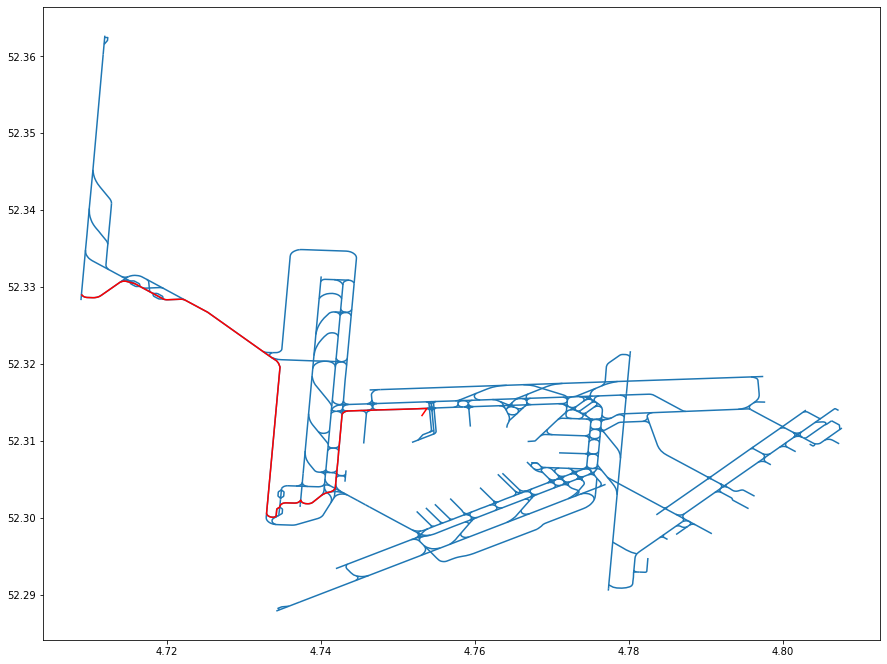

In [23]:
from_node = runways['18R']['end']
to_node = stands['G78R']



# One is only allowed to use taxiways for routing between two places
# hence we perform our shortest path operation on the subgraph induced
# by only keeping taxiway edges
def filter_taxiways_on_graph(G):
    def inner(x, y):
        return G[x][y]['type'] == 'taxiway'
    
    return inner

taxiway_G = nx.subgraph_view(G, filter_edge=filter_taxiways_on_graph(G))



nodes_in_path = nx.shortest_path(taxiway_G, source=from_node, target=to_node, weight='length')

ax = taxiway_paths.plot(figsize=(15, 15))
ax = runway_paths.plot(figsize=(15,15), ax=ax)
gpd.GeoDataFrame([[]], geometry=[LineString(nodes_in_path)]).plot(ax=ax, color='red')

# Building the environment

To build the environment we'll need a few components:

- A `Vehicle` or `Aircraft` that represents an actual object moving over the airfield
- A `Flight` that represents a scheduled inbound or outbound flight. A flight is executed by an `Aircraft`
- A `Router` that is used by a `Flight` to determine which trajectory the physical `Aircraft` should follow from runway to gate or vice versa.

In [100]:
class Vehicle(object):
    def __init__(self, position, altitude=0):
        self.position = position
        self.altitude = altitude
        self.speed = 0
        self.vert_speed = 0
        self.destination = None
    
    def set_trajectory(self, coords):
        self._remaining_waypoints = coords
        self._next_waypoint = self._remaining_waypoints.pop(0)
        self.destination = coords[-1]
        
    def step(self, time_pased=1):
        if self._next_waypoint is None:
            return self.position
        
        # Initialize the distance to travel in this timestep. We'll traverse the edges in the
        # trajectory step by step and substract the distance travelled for each edge from this
        # total distance that needs to be travelled.
        remaining_distance_to_travel = self.speed * time_pased
        distance_to_next_waypoint = haversine(*self.position, *self._next_waypoint)
        
        while distance_to_next_waypoint < remaining_distance_to_travel:
            # As long as the distance to the next waypoint in the trajectory is samller than the
            # remaining distance to travel, we will fully traverse this edge in the current time step
            remaining_distance_to_travel -= haversine(*self.position, *self._next_waypoint)
            self.position = self._next_waypoint
            
            if len(self._remaining_waypoints) > 0:
                # As long as there are more edges along the trajectory remaining, we can start by
                # traversing the next one.
                self._next_waypoint = self._remaining_waypoints.pop(0)
                distance_to_next_waypoint = haversine(*self.position, *self._next_waypoint)
            else:
                # If there are not edges remaining stop the Aircraft at the endpoint of the trajectory
                # and return.
                self.speed = 0
                self.position = self._next_waypoint
                self._next_waypoint = None
                
                return self.position
        
        # After crossing all edges in full it might be we've only ended up somwhere in the middle
        # of an edge in the current timesstep. Then we interpolate where on that edge we are.
        # This linear approximation only works out because of the very small size of the total
        # airport
        alpha = remaining_distance_to_travel / distance_to_next_waypoint
        self.position = (
            self.position[0] + alpha * (self._next_waypoint[0] - self.position[0]),
            self.position[1] + alpha * (self._next_waypoint[1] - self.position[1])
        )
        
        return self.position
    
class Aircraft(Vehicle):
    pass

In [101]:
class Router:
    def __init__(self, graph, runways, ramps):
        self.graph = graph
        self.runways = runways
        self.ramps = ramps
        
    def get_runway(self, name, exit=False):
        if exit:
            return self.runways[name]['end']
        else:
            return self.runways[name]['start']
    
    def get_ramp(self, name):
        return self.ramps[name]
    
    def find_taxi_route(self, from_node, to_node):
        def filter_taxiways_on_graph(G):
            def inner(x, y):
                return G[x][y]['type'] == 'taxiway'
            return inner

        G_taxiway_subgraph = nx.subgraph_view(G, filter_edge=filter_taxiways_on_graph(G))

        return nx.shortest_path(G_taxiway_subgraph, source=from_node, target=to_node, weight='length')

In [102]:
class Flight(object):
    def __init__(self,
                 direction,
                 appear_time,
                 runway,
                 ramp):
        self.direction = direction
        self.appear_time = appear_time
        self.runway = runway
        self.ramp = ramp
        
        self._aircraft = None
        
    @property
    def aircraft(self):
        if self._aircraft is None:
            raise AttributeError('The physical aircraft for this flight still needs to be initialized.')
        else:
            return self._aircraft
        
    def initialize_aircraft(self, router):
        runway_node = router.get_runway(self.runway, exit=(self.direction == 'A'))
        ramp_node = router.get_ramp(self.ramp)
        
        
        if self.direction == 'A':
            start_node = runway_node
            end_node = ramp_node
        else:
            start_node = ramp_node
            end_node = runway_node
        
        self._aircraft = Aircraft(
            position=start_node
        )
        
        self._aircraft.set_trajectory(
            router.find_taxi_route(start_node, end_node)
        )
        
        return self._aircraft
        
        

## Routing example
Using these three simple objects we can make a quick example that shows how a flight moves over the airfield.

In [103]:
# Define the router, the flight and initiale the aircraft for that flight
router = Router(G, runways, stands)
flight = Flight(direction='D', appear_time=0, runway='36R', ramp='D4')
aircraft = flight.initialize_aircraft(router)


# Executy a as many timesteps needed to get to the target position
aircraft.speed = 10
travelled_trajectory = []
while True and aircraft.speed > 0:
    travelled_trajectory.append(aircraft.step(1))

Let's visualize the trajectory travelled by this object on the airport map.

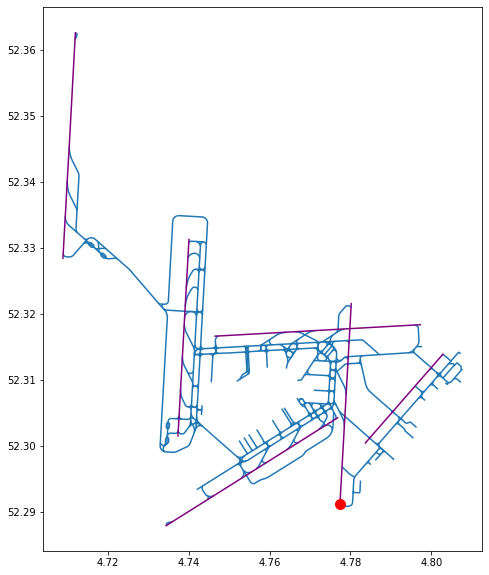

In [104]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

taxiway_paths.plot(ax=ax)
runway_paths.plot(ax=ax, color='purple')

flight_track, = ax.plot([], [], linestyle='none', marker='o', ms=10, c='red')

def init():
    return (flight_track,)

def animate(i):
    flight_track.set_data([travelled_trajectory[i][0]], [travelled_trajectory[i][1]])
    
    return (flight_track,)

ani = animation.FuncAnimation(fig, animate, len(travelled_trajectory), init_func=init,
                              interval=100, blit=True)
display(HTML(ani.to_html5_video()))

In [ ]:
runway_configurations = [
    {
        'A': ['36R'],
        'D': ['36L', '24']
    },
    {
        'A': ['27'],
        'D': ['18R']
    }
]

# Simulate a random flight operation.
Now that we've shown that we can succesfully route a single vehicle across the airfield, it is time to do the same for a multitude of vehicles. Therefore we'll create a random flight schedule (with random gate assignments) and plot the aircraft moving over the airfield for this flight schedule. From this it'll be only a minor step to creating a gym Environment where we can control each aircraft by taking `stop` and `start` actions.

First, we'll need a few methods to create random flight schedules. For this we sample a timestep at which the flight should appear, a runway where the flight should land or depart and a gate the flight will use.

In [ ]:
import random

def generate_random_flight(direction, max_appear_time, ramps, runways):
    return Flight(
        appear_time=random.randint(0, max_appear_time),
        direction=direction,
        ramp=random.choice(ramps),
        runway=random.choice(runways)
    )


def generate_random_flight_schedule(simulation_time, runway_configuration, ramps, n_inbound=40, n_outbound=40):
    outbound_flights = [
        generate_random_flight('D', simulation_time, ramps, runway_configuration['D']) for _ in range(n_outbound)
    ]
    
    inbound_flights = [
        generate_random_flight('A', simulation_time, ramps, runway_configuration['A']) for _ in range(n_inbound)
    ]
    
    return outbound_flights + inbound_flights
    

In [ ]:
MAX_SIMULATION_TIME = 3600


fs = generate_random_flight_schedule(
    simulation_time=MAX_SIMULATION_TIME,
    runway_configuration=runway_configurations[0],
    ramps=list(stands.keys()),
    n_inbound=60,
    n_outbound=60
)

aircrafts = [flight.initialize_aircraft(router) for flight in fs]

for aircraft in aircrafts:
    aircraft.speed = 10

## Computing trajectories
In the simulation not every flight will be active at all time steps. The flight might have departed or might have arrived at the gate already. Therefore we'll create some utility methods to determine whether a flight is active and hence whether it should be included in plotting the trajectories for each timestep.

In [ ]:
def get_active_aircraft(current_time, flight_schedule):
    return [
        flight.aircraft 
        for flight in flight_schedule
        if (
            flight.aircraft.position != flight.aircraft.destination and
            flight.appear_time <= current_time
        )    
    ]

Next, we'll loop through time. For each flight that was _active_ at a certain timestep we'll compute the next position (given the current speed) and store these positions for later plotting.

In [ ]:
trajectories = []

for t in range(MAX_SIMULATION_TIME):
    active_aircraft = get_active_aircraft(t, fs)
    
    positions_at_timestep = []
    
    for aircraft in active_aircraft:
        aircraft.step(1)
        
        positions_at_timestep.append(aircraft.position)
        
    trajectories.append(positions_at_timestep)

In [ ]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

taxiway_paths.plot(ax=ax)
runway_paths.plot(ax=ax, color='purple')

flight_track, = ax.plot([], [], linestyle='none', marker='o', ms=5, c='red')

def init():
    return (flight_track,)

def animate(i):
    positions_at_timestep = np.array(trajectories[i], ndmin=2)
    if positions_at_timestep.shape[1] == 2:
        flight_track.set_data(positions_at_timestep[:, 0], positions_at_timestep[:, 1])
    else:
        flight_track.set_data([], [])
    
    return (flight_track,)

ani = animation.FuncAnimation(fig, animate, len(trajectories), init_func=init,
                              interval=100, blit=True)
display(HTML(ani.to_html5_video()))

In [105]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

taxiway_paths.plot(ax=ax)
runway_paths.plot(ax=ax, color='purple')

flight_track, = ax.plot([], [], linestyle='none', marker='o', ms=5, c='red')

def init():
    return (flight_track,)

def animate(i):
    positions_at_timestep = np.array(trajectories[i], ndmin=2)
    if positions_at_timestep.shape[1] == 2:
        flight_track.set_data(positions_at_timestep[:, 0], positions_at_timestep[:, 1])
    else:
        flight_track.set_data([], [])
    
    return (flight_track,)

ani = animation.FuncAnimation(fig, animate, len(trajectories), init_func=init,
                              interval=100, blit=True)
display(HTML(ani.to_html5_video()))

# Simulate a random flight operation.
Now that we've shown that we can succesfully route a single vehicle across the airfield, it is time to do the same for a multitude of vehicles. Therefore we'll create a random flight schedule (with random gate assignments) and plot the aircraft moving over the airfield for this flight schedule. From this it'll be only a minor step to creating a gym Environment where we can control each aircraft by taking `stop` and `start` actions.

First, we'll need a few methods to create random flight schedules. For this we sample a timestep at which the flight should appear, a runway where the flight should land or depart and a gate the flight will use.

In [134]:
import random

def generate_random_flight(direction, max_appear_time, ramps, runways):
    return Flight(
        appear_time=random.randint(0, max_appear_time),
        direction=direction,
        ramp=random.choice(ramps),
        runway=random.choice(runways)
    )


def generate_random_flight_schedule(simulation_time, runway_configuration, ramps, n_inbound=40, n_outbound=40):
    outbound_flights = [
        generate_random_flight('D', simulation_time, ramps, runway_configuration['D']) for _ in range(n_outbound)
    ]
    
    inbound_flights = [
        generate_random_flight('A', simulation_time, ramps, runway_configuration['A']) for _ in range(n_inbound)
    ]
    
    return outbound_flights + inbound_flights
    

In [ ]:
MAX_SIMULATION_TIME = 3600


fs = generate_random_flight_schedule(
    simulation_time=MAX_SIMULATION_TIME,
    runway_configuration=runway_configurations[0],
    ramps=list(stands.keys()),
    n_inbound=60,
    n_outbound=60
)

aircrafts = [flight.initialize_aircraft(router) for flight in fs]

for aircraft in aircrafts:
    aircraft.speed = 10

## Computing trajectories
In the simulation not every flight will be active at all time steps. The flight might have departed or might have arrived at the gate already. Therefore we'll create some utility methods to determine whether a flight is active and hence whether it should be included in plotting the trajectories for each timestep.

In [135]:
def get_active_aircraft(current_time, flight_schedule):
    return [
        flight.aircraft 
        for flight in flight_schedule
        if (
            flight.aircraft.position != flight.aircraft.destination and
            flight.appear_time <= current_time
        )    
    ]

Next, we'll loop through time. For each flight that was _active_ at a certain timestep we'll compute the next position (given the current speed) and store these positions for later plotting.

In [138]:
trajectories = []

for t in range(MAX_SIMULATION_TIME):
    active_aircraft = get_active_aircraft(t, fs)
    
    positions_at_timestep = []
    
    for aircraft in active_aircraft:
        aircraft.step(1)
        
        positions_at_timestep.append(aircraft.position)
        
    trajectories.append(positions_at_timestep)

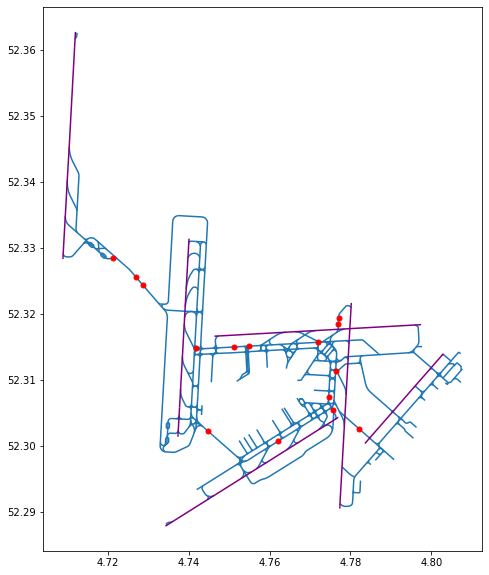

In [139]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

taxiway_paths.plot(ax=ax)
runway_paths.plot(ax=ax, color='purple')

flight_track, = ax.plot([], [], linestyle='none', marker='o', ms=5, c='red')

def init():
    return (flight_track,)

def animate(i):
    positions_at_timestep = np.array(trajectories[i], ndmin=2)
    if positions_at_timestep.shape[1] == 2:
        flight_track.set_data(positions_at_timestep[:, 0], positions_at_timestep[:, 1])
    else:
        flight_track.set_data([], [])
    
    return (flight_track,)

ani = animation.FuncAnimation(fig, animate, len(trajectories), init_func=init,
                              interval=100, blit=True)
display(HTML(ani.to_html5_video()))